In [65]:
import pandas as pd

In [66]:
import numpy as np

In [68]:
from sklearn.linear_model import LinearRegression


In [69]:
import matplotlib.pyplot as plt


In [70]:
from math import sqrt

In [71]:
# Load training datasets (A)
train_data1 = pd.read_csv('/content/train.csv')

In [72]:
# Load test dataset (B)
test_data = pd.read_csv('/content/test.csv')


In [75]:
# Load ideal functions datasets (C)
ideal_functions = []
for i in range(1, 51):
    ideal_functions.append(pd.read_csv(f'/content/ideal.csv'))


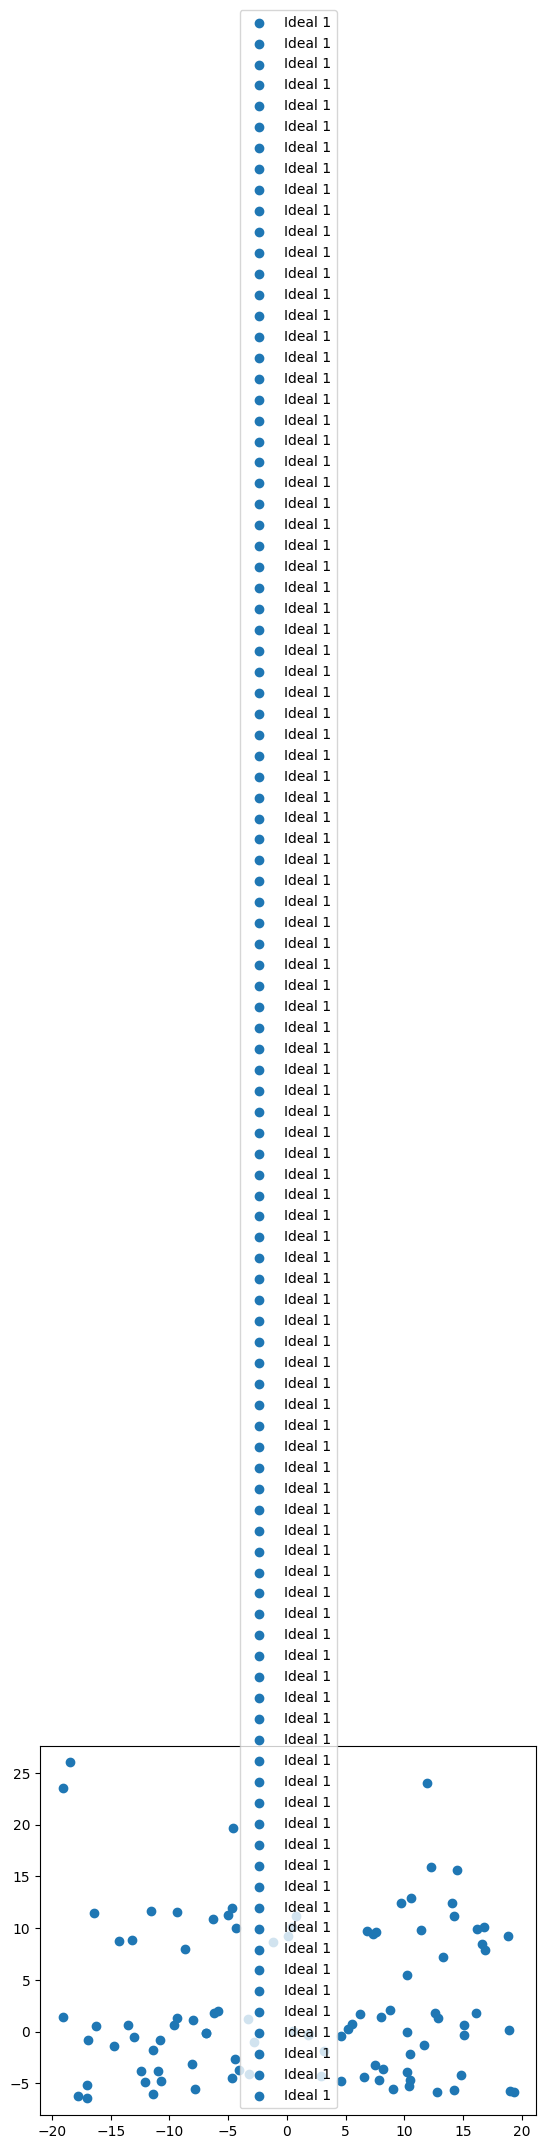

In [85]:
# Function to calculate the sum of squared deviations for a given regression model
def calculate_deviation(model, x, y):
    y_pred = model.predict(x.reshape(-1, 1))
    deviation = np.sum((y - y_pred) ** 2)
    return deviation

# Function to choose the best fit ideal functions using least squares
def choose_ideal_functions(training_data, ideal_functions):
    best_fit_functions = []

    for i, ideal_function in enumerate(ideal_functions):
        x_ideal, y_ideal = ideal_function['x'], ideal_function['y1']
        deviation_sum = 0

        for dataset in training_data:
            x_train, y_train = dataset['x'], dataset['y1']
            model = LinearRegression().fit(x_train.values.reshape(-1, 1), y_train.values)
            deviation_sum += calculate_deviation(model, x_ideal.values, y_ideal.values)

        best_fit_functions.append((i+1, deviation_sum))

    # Sort by deviation sum in ascending order
    best_fit_functions.sort(key=lambda x: x[1])

    return best_fit_functions[:4]  # Choose the top 4 ideal functions

# Function to map test data to chosen ideal functions and save results
def map_test_data(chosen_ideal_functions, test_data, ideal_functions):
    results = []

    for index, row in test_data.iterrows():
        x_test, y_test = row['x'], row['y']
        deviations = []

        for i, (ideal_index, _) in enumerate(chosen_ideal_functions):
            x_ideal, y_ideal = ideal_functions[ideal_index - 1]['x'], ideal_functions[ideal_index - 1]['y1']
            model = LinearRegression().fit(x_ideal.values.reshape(-1, 1), y_ideal.values)
            deviation = calculate_deviation(model, np.array(x_test), np.array(y_test))
            deviations.append((i+1, deviation))

        deviations.sort(key=lambda x: x[1])

        if deviations[0][1] <= deviations[1][1] * sqrt(2):
            results.append((x_test, y_test, deviations[0][0], deviations[0][1]))

    return results

# Choose the best fit ideal functions
chosen_ideal_functions = choose_ideal_functions([train_data1], ideal_functions)

# Map test data to chosen ideal functions and save results
mapped_results = map_test_data(chosen_ideal_functions, test_data, ideal_functions)

# Visualize the data
for result in mapped_results:
    plt.scatter(result[0], result[1], color=f'C{result[2]-1}', label=f'Ideal {result[2]}')

plt.legend()
plt.show()


<ipython-input-86-16dc09d1d373>:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


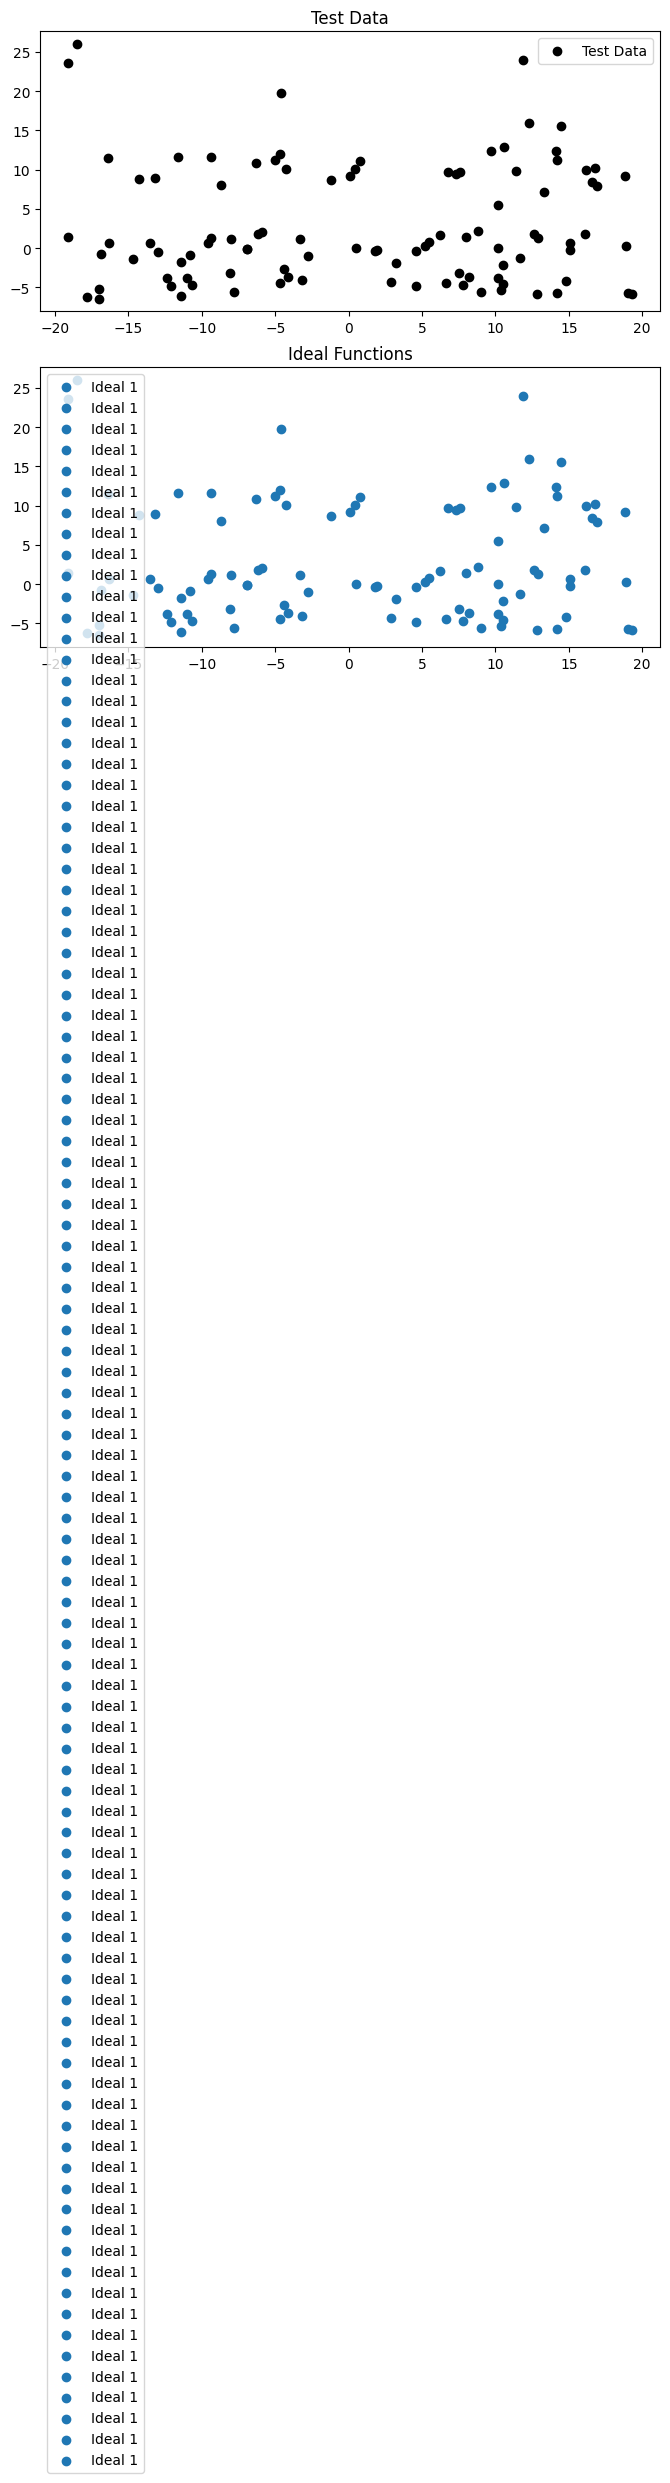

In [86]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Visualize the test data
ax1.scatter(test_data['x'], test_data['y'], color='black', label='Test Data')
ax1.legend()
ax1.set_title('Test Data')

# Visualize the ideal functions
for result in mapped_results:
    ax2.scatter(result[0], result[1], color=f'C{result[2]-1}', label=f'Ideal {result[2]}')

ax2.legend()
ax2.set_title('Ideal Functions')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


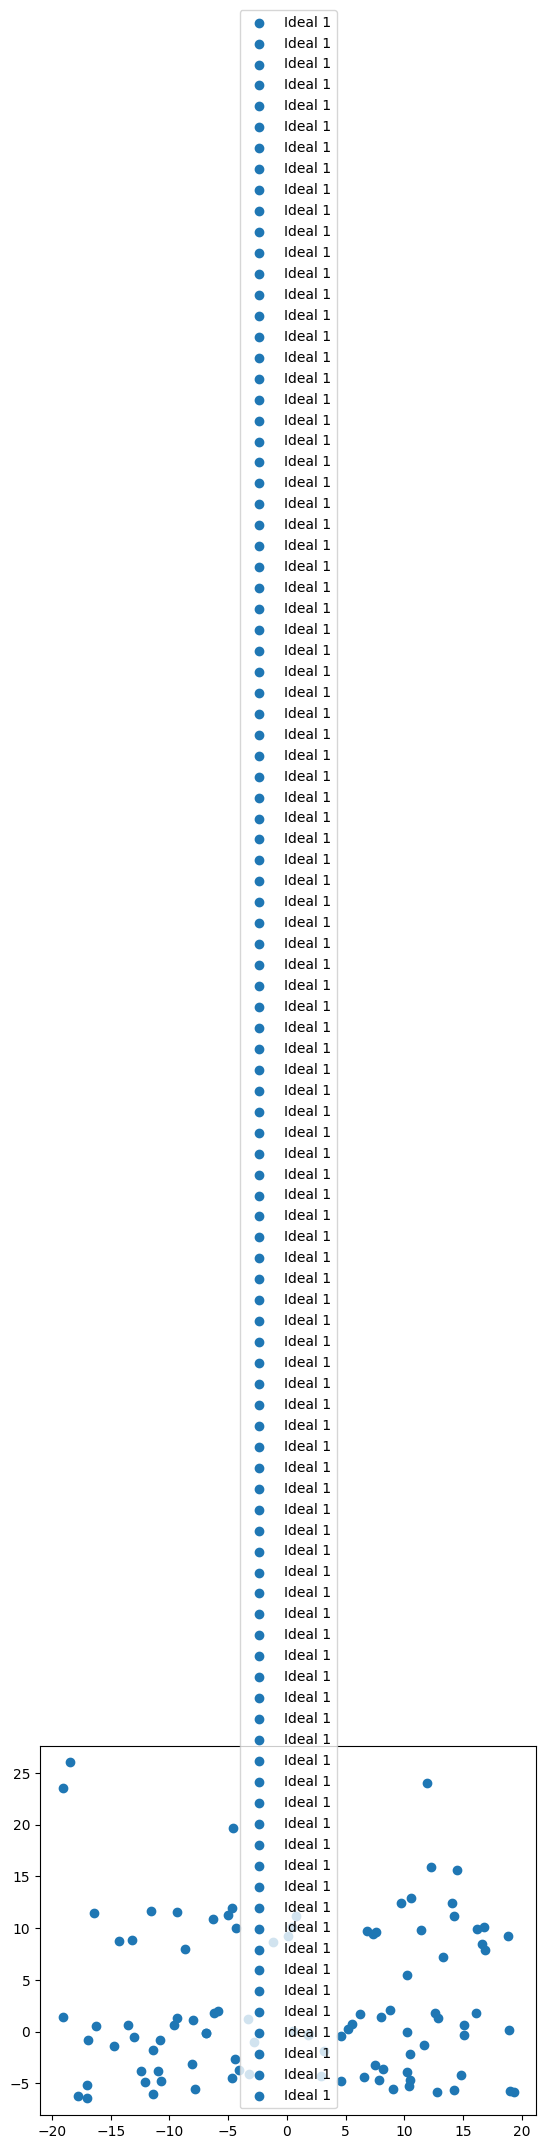

In [87]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from math import sqrt
from sqlalchemy import create_engine, Column, Integer, Float, MetaData, Table
from sqlalchemy.orm import declarative_base, Session
import matplotlib.pyplot as plt
import numpy as np

# Define the SQLite database and tables
Base = declarative_base()

class TrainingData(Base):
    __tablename__ = 'training_data'
    id = Column(Integer, primary_key=True)
    x = Column(Float)
    y1 = Column(Float)
    y2 = Column(Float)
    y3 = Column(Float)
    y4 = Column(Float)

class IdealFunctions(Base):
    __tablename__ = 'ideal_functions'
    id = Column(Integer, primary_key=True)
    x = Column(Float)
    y_values = [Column(Float) for _ in range(50)]

class TestDataResult(Base):
    __tablename__ = 'test_data_result'
    id = Column(Integer, primary_key=True)
    x = Column(Float)
    y = Column(Float)
    chosen_ideal_function = Column(Integer)
    deviation = Column(Float)

# Function to calculate the sum of squared deviations for a given regression model
def calculate_deviation(model, x, y):
    y_pred = model.predict(x.reshape(-1, 1))
    deviation = np.sum((y - y_pred) ** 2)
    return deviation

# Function to choose the best fit ideal functions using least squares
def choose_ideal_functions(training_data, ideal_functions):
    best_fit_functions = []

    for i, ideal_function in enumerate(ideal_functions):
        x_ideal, y_ideal = ideal_function['x'], ideal_function['y1']
        deviation_sum = 0

        for dataset in training_data:
            x_train, y_train = dataset['x'], dataset['y1']
            model = LinearRegression().fit(x_train.values.reshape(-1, 1), y_train.values)
            deviation_sum += calculate_deviation(model, x_ideal.values, y_ideal.values)

        best_fit_functions.append((i+1, deviation_sum))

    # Sort by deviation sum in ascending order
    best_fit_functions.sort(key=lambda x: x[1])

    return best_fit_functions[:4]  # Choose the top 4 ideal functions

# Function to map test data to chosen ideal functions and save results
def map_test_data(chosen_ideal_functions, test_data, ideal_functions, session):
    results = []

    for index, row in test_data.iterrows():
        x_test, y_test = row['x'], row['y']
        deviations = []

        for i, (ideal_index, _) in enumerate(chosen_ideal_functions):
            x_ideal, y_ideal = ideal_functions[ideal_index - 1]['x'], ideal_functions[ideal_index - 1]['y1']
            model = LinearRegression().fit(x_ideal.values.reshape(-1, 1), y_ideal.values)
            deviation = calculate_deviation(model, np.array(x_test), np.array(y_test))
            deviations.append((i+1, deviation))

        deviations.sort(key=lambda x: x[1])

        if deviations[0][1] <= deviations[1][1] * sqrt(2):
            results.append((x_test, y_test, deviations[0][0], deviations[0][1]))

            # Save results to SQLite database
            test_data_result = TestDataResult(
                x=x_test,
                y=y_test,
                chosen_ideal_function=deviations[0][0],
                deviation=deviations[0][1]
            )
            session.add(test_data_result)
            session.commit()

    return results

# Load data into DataFrames (train_data1, ideal_functions, test_data)
# ...

# Create SQLite database engine
database_url = 'sqlite:///data.db'
engine = create_engine(database_url)

# Create tables
Base.metadata.create_all(engine)

# Create a session
session = Session(engine)

# Choose the best fit ideal functions
chosen_ideal_functions = choose_ideal_functions([train_data1], ideal_functions)

# Map test data to chosen ideal functions and save results to the database
mapped_results = map_test_data(chosen_ideal_functions, test_data, ideal_functions, session)

# Visualize the data
for result in mapped_results:
    plt.scatter(result[0], result[1], color=f'C{result[2]-1}', label=f'Ideal {result[2]}')

plt.legend()
plt.show()

# Close the database session
session.close()
